# Project 1: Integration of Mergesort & Insertion Sort

In Mergesort, when the sizes of subarrays are small, the overhead of many recursive
calls makes the algorithm inefficient. Therefore, in real use, we often combine
Mergesort with Insertion Sort to come up with a hybrid sorting algorithm for better
efficiency. The idea is to set a small integer S as a threshold for the size of subarrays.
Once the size of a subarray in a recursive call of Mergesort is less than or equal to S,
the algorithm will switch to Insertion Sort, which is efficient for small-sized input.

In [1]:
import concurrent.futures
import csv
# import math
import random
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# from pydantic import BaseModel, Field, field_validator

(a) Algorithm implementation: Implement the above hybrid algorithm.

In [2]:
class Solution:
    def __init__(self, merge_sort_threshold: int):
        self.merge_sort_threshold: int = merge_sort_threshold
        self.key_comparisons = 0

    def sortArray(self, nums: List[int]) -> List[int]:
        self.arr = nums
        self.mergeSort(0, len(nums) - 1)
        return self.arr

    def insertionSort(self, start_idx: int, end_idx: int):
        if end_idx - start_idx < 1:
            return

        # Binary search
        for current_idx in range(start_idx + 1, end_idx + 1):
            current_value = self.arr[current_idx]
            left, right = start_idx, current_idx - 1

            while left <= right:
                self.key_comparisons += 1
                mid = (left + right) // 2
                if self.arr[mid] > current_value:
                    right = mid - 1
                else:
                    left = mid + 1

            self.arr[left+1:current_idx+1] = self.arr[left:current_idx]

            self.arr[left] = current_value
        return

    def mergeSort(self, start_idx: int, end_idx: int):
        if end_idx - start_idx < self.merge_sort_threshold:
            self.insertionSort(start_idx, end_idx)
            return

        mid_idx = (start_idx + end_idx) // 2
        self.mergeSort(start_idx, mid_idx)
        self.mergeSort(mid_idx + 1, end_idx)
        self.mergeArray(start_idx, mid_idx, end_idx)

    def mergeArray(self, start_idx: int, mid_idx: int, end_idx: int):
        left_part = self.arr[start_idx:mid_idx + 1]
        right_part = self.arr[mid_idx + 1:end_idx + 1]

        left_idx = 0
        right_idx = 0
        sorted_idx = start_idx

        while left_idx < len(left_part) and right_idx < len(right_part):
            if left_part[left_idx] <= right_part[right_idx]:
                self.arr[sorted_idx] = left_part[left_idx]
                left_idx += 1
            else:
                self.arr[sorted_idx] = right_part[right_idx]
                right_idx += 1
            sorted_idx += 1
            self.key_comparisons += 1

        while left_idx < len(left_part):
            self.arr[sorted_idx] = left_part[left_idx]
            left_idx += 1
            sorted_idx += 1

        while right_idx < len(right_part):
            self.arr[sorted_idx] = right_part[right_idx]
            right_idx += 1
            sorted_idx += 1

        return

(b) Generate input data: Generate arrays of increasing sizes, in a range from
1,000 to 10 million. For each of the sizes, generate a random dataset of integers
in the range of [1, …, x], where x is the largest number you allow for your
datasets.

In [3]:
GENERATE_DATA = False
OVERWRITE_EXISTING_DATA = False

DATASET_MIN_SIZE: int = 1000
DATASET_MAX_SIZE: int = int(1e7)
DATASET_SIZE_STEP: int = int(1e5)
DATASET_MAX_VALUE: int = int(1e4)
DATA_CSV_FILENAME: str = 'project_1_datasets.csv'

if GENERATE_DATA:
    with open(DATA_CSV_FILENAME, mode= 'w' if OVERWRITE_EXISTING_DATA else 'a', newline='') as file:
        writer = csv.writer(file)

        for size in tqdm(
            range(DATASET_MIN_SIZE, DATASET_MAX_SIZE+DATASET_SIZE_STEP, DATASET_SIZE_STEP),
            desc="Generating Datasets CSV...",
            unit="dataset",
            dynamic_ncols=True,
            disable=False
        ):
            writer.writerow(np.random.randint(1, DATASET_MAX_VALUE + 1, size).tolist())

In [4]:
# class TestDataset(BaseModel):
#     size: int
#     datasets: List[List[int]] = Field(..., min_items=DATASETS_PER_SIZE, max_items=DATASETS_PER_SIZE)

# #     @field_validator("datasets")
# #     @classmethod
# #     def check_num_datasets(cls, datasets, values):
# #         if len(datasets) != DATASETS_PER_SIZE:
# #             raise ValueError(f"Required {DATASETS_PER_SIZE} datasets, got {len(datasets)}")
# #         return datasets

#     @field_validator("datasets")
#     @classmethod
#     def check_dataset_size(cls, datasets, values):
#         size = values.data.get("size")
#         if size:
#             for dataset in datasets:
#                 if len(dataset) != size:
#                     raise ValueError(f"Each dataset must have {size} elements, got {len(dataset)}")
#         return datasets

(c) Analyze time complexity: Run your program of the hybrid algorithm on the
datasets generated in Step (b). Record the number of key comparisons
performed in each case.

In [5]:
# class PerformanceData(BaseModel):
#     dataset_size: int
#     insert_sort_threshold: int = Field(..., ge=1)
#     time: float

PerformanceData = Tuple[int, int, int]  # (dataset_size, insert_sort_threshold, key_comparisons)
RESULTS_COLUMNS = ["dataset_size", "insert_sort_threshold", "key_comparisons"]

In [6]:
# DATASET_MIN_SIZE = 1000
# DATASET_MAX_SIZE = 1001 # int(1e7+1)
# RUNS_PER_SIZE: int = 1

# performance_data: List[PerformanceData] = []

# for dataset_size in range(DATASET_MIN_SIZE, DATASET_MAX_SIZE):
#     for test_run in range(RUNS_PER_SIZE):
#         dataset = [random.randint(1, DATASET_MAX_SIZE) for _ in range(dataset_size)]
#         for insert_sort_threshold in range(1, 1001):
#             solution = Solution(insert_sort_threshold)
#             start_time = time.perf_counter()
#             solution.sortArray(dataset)
#             elapsed_time = time.perf_counter() - start_time

#             performance_data.append(
#                 PerformanceData(
#                     dataset_size=dataset_size,
#                     insert_sort_threshold=insert_sort_threshold,
#                     time=elapsed_time
#                 )
#             )

In [7]:
PROCESS_DATA = True
OVERWRITE_EXISTING_RESULTS = True

RESULTS_CSV_FILENAME: str = 'project_1_results.csv'

INSERT_SORT_THRESHOLDS = [10**power for power in range(6)]

# DATASET_MAX_VALUE: int = int(1e3)
# DATASET_SIZE_STEP: int = int(1e6)
# DATASET_MIN_SIZE: int = 1000
# DATASET_MAX_SIZE: int = int(1e7)

if PROCESS_DATA:
    is_initial_run: bool = True
    for dataset_size in tqdm(
        # range(
        #     DATASET_MIN_SIZE,
        #     DATASET_MAX_SIZE+DATASET_SIZE_STEP*(DATASET_MIN_SIZE // DATASET_SIZE_STEP + 1),
        #     DATASET_SIZE_STEP
        # )
        [10**power for power in range(3, 8)],
        desc="Calculating Sort Times...",
        unit="threshold sets",
        dynamic_ncols=True,
        disable=False
    ):
        with open(
            RESULTS_CSV_FILENAME,
            mode= 'w' if OVERWRITE_EXISTING_RESULTS and is_initial_run else 'a',
            newline=''
        ) as result_file:
            is_initial_run = False
            writer = csv.writer(result_file)
            dataset: List[int] = np.random.randint(1, DATASET_MAX_VALUE + 1, dataset_size).tolist()

            for insert_sort_threshold in INSERT_SORT_THRESHOLDS:
                solution = Solution(insert_sort_threshold)
                solution.sortArray(dataset.tolist())

                writer.writerow((dataset_size, insert_sort_threshold, solution.key_comparisons))

Calculating Sort Times...: 100%|██████████| 5/5 [55:52<00:00, 670.51s/datasets] 


In [8]:
df = pd.read_csv(RESULTS_CSV_FILENAME, names=RESULTS_COLUMNS)
df

,dataset_size,insert_sort_threshold,key_comparisons
0,1000,1,8692
1,1000,10,8678
2,1000,100,8619
3,1000,1000,8604
4,1000,10000,8604
5,1000,100000,8604
6,10000,1,120378
7,10000,10,119986
8,10000,100,119268
9,10000,1000,119023


i. With the value of S fixed, plot the number of key comparisons over
different sizes of the input list n. Compare your empirical results with
your theoretical analysis of the time complexity.
<br><br>
Note: S=1 represents pure merge sort


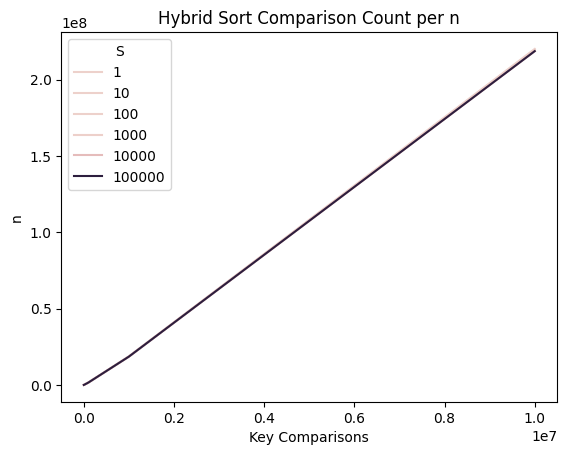

In [9]:
plot_1 = sns.lineplot(
    data=df,
    x="dataset_size",
    y="key_comparisons",
    hue="insert_sort_threshold"
)
plot_1.set(
    xlabel ="Key Comparisons",
    ylabel = "n",
    title ='Hybrid Sort Comparison Count per n'
)

plt.legend(title="S")
plt.show()

ii. With the input size n fixed, plot the number of key comparisons over
different values of S. Compare your empirical results with your
theoretical analysis of the time complexity.
<br><br>
Note: S=1 represents pure merge sort

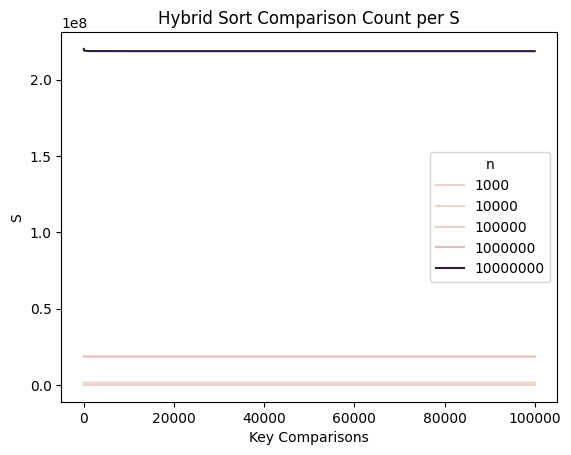

In [10]:
plot_2 = sns.lineplot(
    data=df,
    x="insert_sort_threshold",
    y="key_comparisons",
    hue="dataset_size"
)
plot_2.set(
    xlabel ="Key Comparisons",
    ylabel = "S",
    title ='Hybrid Sort Comparison Count per S'
)

plt.legend(title="n")
plt.show()

iii. Using different sizes of input datasets, study how to determine an
optimal value of S for the best performance of this hybrid algorithm.

In [11]:
df.loc[
    df.groupby("dataset_size")["key_comparisons"].idxmin(),
    ["dataset_size", "insert_sort_threshold"]
].reset_index(drop=True)

,dataset_size,insert_sort_threshold
0,1000,1000
1,10000,1000
2,100000,10000
3,1000000,100000
4,10000000,100000
